### Task 2 Prompt


Prepare 4 random 4-qubit quantum states of your choice.

Create and train a variational circuit that transforms input states into predefined output states. Namely

- if random state 1 is provided, it returns state |0011>
- if random state 2 is provided, it returns state |0101>
- if random state 3 is provided, it returns state |1010>
- if random state 4 is provided, it returns state |1100>

What would happen if you provided a different state?

Analyze and discuss the results.



- Note that this notebook uses big-edian notation, meaning that the left-most bit in the bitstring is the most significant bit.

#### Introduction

The notebook is organized as follow. In section 1, we rephrase of the task to simplify the construction process. In section 2, we define the cost function, build the variational circuit, and train the circuit by classical unitary simulation on an optimizer. In section 3, we introduce a method in the literature for constructing $n$-qubit unitary gate and benchmark it against Qiskit's construction. In section 4, we introduce a hybrid algorithm that uses the SWAP test to compare the general unitary built in section 3 to a variational circuit for a possible optimization in circuit depth.

### 1. Rephrasing the Problem

In mathematical terms, for random states $\{\vec{v}_1, \vec{v}_2, \vec{v}_3, \vec{v}_4\}$, we find a matrix $M \in U(16)$ that satisfies (up to a global phase)

$$M\vec{v}_1 = |0011\rangle, \quad M\vec{v}_2 = |0101\rangle, \quad M\vec{v}_3 = |1010\rangle, \quad M\vec{v}_4 = |1100\rangle$$

Since unitary matrix are bijective transformations, we have the inverse matrix $M^\dagger$ that maps the basis states to the random states. This simplifies the process because we are working in the $z$-basis. This mapping also tells us that all our random states are orthonormal to each other because unitary transformations preserve right angle.

$$M^\dagger|0011\rangle = \vec{v}_1, \quad M^\dagger|0101\rangle = \vec{v}_2, \quad M^\dagger|1010\rangle = \vec{v}_3, \quad M^\dagger|1100\rangle = \vec{v}_4$$

We build our variational circuit as a learning model, start by preparing the basis states inputs $\vec{X}$, and random states output $\vec{y}$. Then, our circuit serves as the cost function, with the $CX$ entanglers and tunable single qubit $U$ gates. Since the problem is in the low-qubit regime, we have decided to classically simulate the circuit with Qiskit's ```unitary_simulator```. At the end of training, we invert our circuit by reversing the order of operations, and change the sign of all the parameters. We would then have the appropriate matrix $M$.

###### Import

In [530]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.visualization import *
from qiskit.circuit.library import *
from sympy import *
import numpy as np

from scipy.optimize import minimize
from qiskit_nature.circuit.library import UCCSD

from qiskit import QuantumCircuit as q

from sympy.physics.quantum import TensorProduct as tp
from scipy.linalg import *

from numpy.testing import assert_almost_equal as aae

from qiskit.extensions import UnitaryGate
import itertools

from qiskit.circuit import Parameter

###### Preparing Inputs and Outputs

$$M^\dagger|0011\rangle = \vec{v}_1, \quad M^\dagger|0101\rangle = \vec{v}_2, \quad M^\dagger|1010\rangle = \vec{v}_3, \quad M^\dagger|1100\rangle = \vec{v}_4$$

In [608]:
### Define input
x1 = Statevector.from_label('0011').data.reshape(16, 1) # 3
x2 = Statevector.from_label('0101').data.reshape(16, 1) # 5
x3 = Statevector.from_label('1010').data.reshape(16, 1) # 10
x4 = Statevector.from_label('1100').data.reshape(16, 1) # 12

X = np.block([x1, x2, x3, x4]) # vectorized inputs

### Define random statevectors
random_matrix = random_unitary(dims = 16, seed = 10).data

y = random_matrix[:, [3, 5, 10, 12]] # vectorized outputs

- Note that if the random statevectors are given, we need to orthonormalize them by the Gram-Schmidt process

###### Defining the Cost Function

We use the notation of the complex dot product to quantify (closeness). For two unit-length vectors $u$ and $v$,

$$\begin{align*} |\langle v | u \rangle|^2 &= 0 \quad \text{if } v \perp u \\\\ |\langle v | u \rangle|^2 &= 1 \quad   \text{if } v \parallel u\end{align*}$$

Since our outputs are vectorized as $(16 \times 4)$ block, the result of the dot product will be a $(4 \times 4)$ vectors. Our only entries of interest lies along the diagonal, which gives the proper dot product between corresponding vectors in $y$ and $\hat{y}$. We then define the loss function to be the mean of these values. Finally to follow the convention of "minimizing the loss function", we take $1 - \text{cost}$ to ensure that the values lie between 0 and 1, with 0 being the optimal.

$$\text{loss} = 1 - \frac{  |\langle y_1 | \hat{y}_1  \rangle|^2 + |\langle y_2 | \hat{y}_2  \rangle|^2 + |\langle y_3 | \hat{y}_3  \rangle|^2 + |\langle y_4 | \hat{y}_4  \rangle|^2 }{4}$$

In [609]:
loss = lambda y, yhat: 1 - np.mean(np.abs(np.diag(np.conj(y).T @ yhat)))**2

### 2. The Variational Circuit

We construct our variational circuit with single qubit $U$ gates and $CX$ gates. Our circuit consist of 6 layers, each has a rotation block and an entangling block. The entangling block has a circular entangle map ```[(0, 1), (1, 2), (2, 3), (3, 0)]``` to make sure each qubit are connected to every other qubit directly or indirectly. In total we uses 24 single qubit $U$ gates, for a total of 72 tunable parameters, and 24 $CX$ gate. In practice, the simplest way to build the circuit describe above would be to use Qiskit's ```TwoLocal``` function. However, in our case, we will build everything by hand to make sure that the circuit is faster to train.

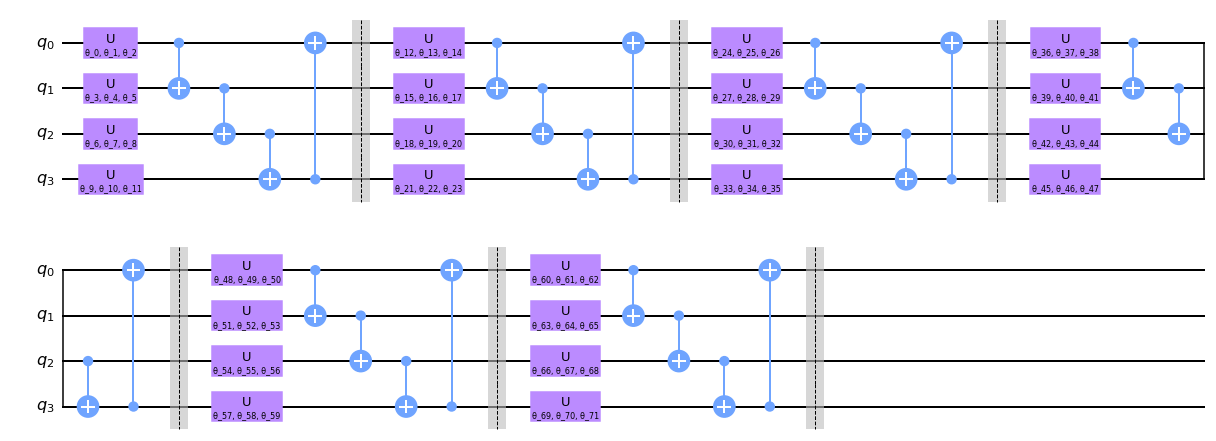

In [610]:
### Define list of circuit parameters
param = [Parameter(f'θ_{i}') for i in range(72)]

ansatz = QuantumCircuit(4)
for layer in range(6):
    ansatz.u(param[12*layer], param[12*layer+1], param[12*layer+2], 0)
    ansatz.u(param[12*layer+3], param[12*layer+4], param[12*layer+5], 1)
    ansatz.u(param[12*layer+6], param[12*layer+7], param[12*layer+8], 2)
    ansatz.u(param[12*layer+9], param[12*layer+10], param[12*layer+11], 3)
    ansatz.cx(0, 1)
    ansatz.cx(1, 2)
    ansatz.cx(2, 3)
    ansatz.cx(3, 0)
    ansatz.barrier()

ansatz.draw('mpl')

##### Incorporating the Variational Circuit into the Cost Function

Our variational circuit will generate the for test state $\hat{y}$ for us to compared against our expected outputs $y$. Since we are working with small qubits, we can simulate the unitary matrix of the entire circuit classically and multiply that by the inputs to get our test state.

In [611]:
def cost(x0):
    
    '''Calculate cost given a set of parameters'''
    
    circ = ansatz.bind_parameters(x0)
    
    Unitary = Operator(circ).data
    
    yhat = Unitary@X
    
    return loss(y, yhat)

###### Training the Circuit

We initialized all $72$ tunable parameters to $0$. Since our cost function is phrase in terms of a minimization problem, we can use the ```scipy.optimize.minimize``` function. Since the possibility space of $72$ parameters is quite big, the optimizer will take around 5 minutes to run. We train the circuit for five sets of random vectors. In the end, we found out that the most optimize set of parameters has the loss value of around ```0.07```.

In [625]:
x0 = res.x

res = minimize(cost, x0, method = 'Nelder-Mead')

In [628]:
### Print optimized parameters
print(res.x)

[ 9.64605559e-01  8.62323413e-02 -7.31419063e-02 -3.97254070e+00
  6.11893321e-01  1.27836962e+00  1.44079572e-01 -2.01865312e-02
 -3.76858198e-01  8.86759556e-01  7.26667917e-01  6.76584917e-01
 -1.07058460e-02 -5.70895685e-01  1.20982582e-01 -6.57961338e-02
 -4.58693700e-01  1.48476293e+00 -2.35237978e-01 -3.40615791e-01
 -1.05084832e+00  2.47980081e-01  1.40233526e+00 -5.57233665e-01
  6.31653338e-01 -1.32005679e+00  1.80793977e-01  1.77792906e+00
  5.50087483e-01  1.30423511e+00 -1.77016770e+00  1.27517343e+00
 -5.07808845e-01 -6.68592138e-01  6.04420771e-02 -2.41631868e-01
  4.64589441e-01 -1.06995256e+00 -8.13022644e-01 -2.31585505e+00
 -4.00433144e-01  7.56701952e-01 -7.13611719e-01 -4.72059233e-01
 -1.59562357e+00 -1.43764078e+00  5.34386382e-01  6.08538803e-01
 -2.82197069e-01  1.58977207e-02 -1.02627591e+00  1.24851360e+00
 -4.14341202e-01 -5.36566208e-01  1.05236332e+00 -1.11916826e+00
 -4.69483856e-01 -2.13007350e-01 -8.83839766e-01  3.78934959e-01
  2.92896538e-01 -1.09746

In [629]:
### Calculate final cost
print(f'loss: {cost(x0)}')

loss: 0.09239339322045603


Finally, we substitute the parameters into our circuit and invert it to get our desired matrix $M$.

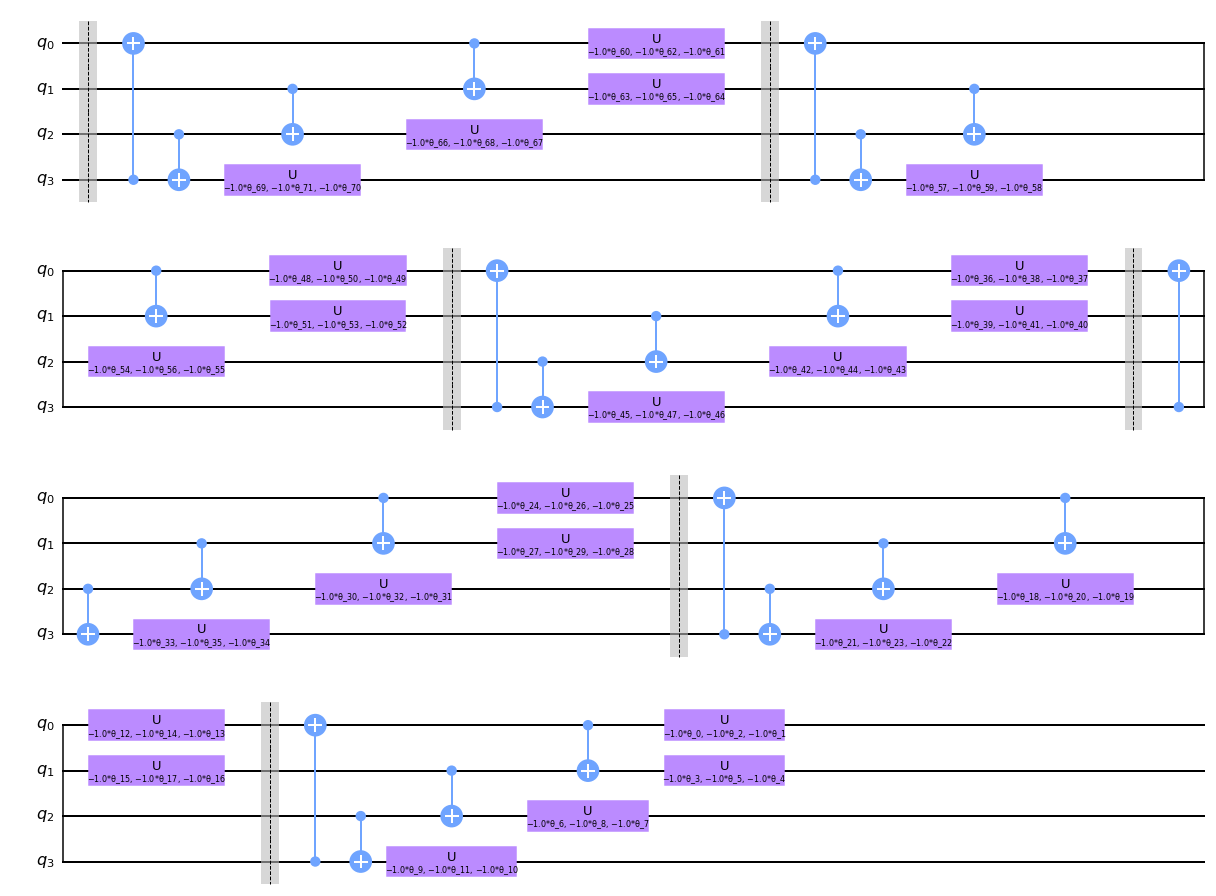

In [630]:
ansatz.bind_parameters(res.x)

### Invert Circuit
ansatz = ansatz.inverse()

ansatz.draw('mpl')

There are rooms to improvement on our variational circuit. For example, we could look to change the structure of the entanglement. There are a few other architecture like ```sca``` and ```full``` that offers an even more extensive entanglement. 

### 3. General $n$-Qubit Unitary Construction

The variational approach is widely used in many quantum algorithms because of its generality and simplicity to implement. However, since our task relates to generating arbitrary states, the variational circuit will have some intrinsic "blind-spot" to it. In this section, we discuss the state-of-the-art method for constructing general $n$-qubit gate. Here we use the technique by Shende and Markov in their [paper](https://arxiv.org/abs/quant-ph/0406176) *Synthesis of Quantum Logic Circuits*. We will outline the specific construction for a $4$-qubits unitary, which subsequently decomposes into four $3$-qubits unitary. These two cases we will build by hand. The final decomposition of sixteen $2$-qubits gates we use Qiskit's method ```transpile```. We optimize for $CX$ gates which are more expensive to implement in practice. In the end, we compare our construction to Qiskit's implementation, and show that there are significant updating to the source code to be made. 

#### Decomposing $U^n$ to $U^{n-1}$

The Cosine-Sine decomposition on a general unitary matrix is given by 

$$U = \begin{pmatrix} B_1 & \\ & B_2 \end{pmatrix} \begin{pmatrix} C & -S \\ S & C \end{pmatrix} \begin{pmatrix}A_1& \\ & A_2\end{pmatrix} \quad \quad (1)$$

We see that the middle matrix represents multiplexed $R_y$ gate acting on the top qubit of the circit. The two outer matrices are controlled unitaries. We can further decompose these to an alternative form. Without loss of generality, let $U_1 = B_1$ and $U_2 = B_2$,

$$U_1 \oplus U_2 = (I\otimes V)(D \oplus D^\dagger)(I\otimes W) \quad\quad (2)$$

where $U_1U_2^\dagger = VD^2V^\dagger$ is a matrix diagonalization. After that, we can work out $W = DV^\dagger U_2$. We can implement $D \oplus D^\dagger$ as a multiplexed $R_z$ gate on the top qubit of the circuit. We repeat the process, this time let $U_1 = A_1$ and $U_2 = A_2$.

The overall scheme is called Quantum Shannon Decomposition. We decompose an $n$-qubit general unitary matrix into 4 $U^{n-1}$, 2 $R_y^n$, 2$R_z^n$. This is an iterative process which we repeat $n-2$ times.

$$U = \underbrace{\begin{pmatrix}U_4 & \\ & U_4 \end{pmatrix} \begin{pmatrix} D_B & \\ & D_B^\dagger \end{pmatrix}\begin{pmatrix}U_3 & \\ & U_3 \end{pmatrix}}_B \cdot \underbrace{\begin{pmatrix} C & -S \\ S & C \end{pmatrix}}_{CS} \cdot \underbrace{\begin{pmatrix}U_2 & \\ & U_2 \end{pmatrix} \begin{pmatrix} D_A & \\ & D_A^\dagger \end{pmatrix}\begin{pmatrix}U_1 & \\ & U_1 \end{pmatrix}}_A\quad\quad (3)$$

- Note that the superscript on a matrix denotes the number of gates that matrix acts on.

- The notion of the multiplexed gate is defined section [3](https://arxiv.org/abs/quant-ph/0406176). This is a generalization of the controlled gate, in which different input state in the control bits activates different action on the target bits.

In [4]:
### Helpful Linear Algebra Functions

def diagonalize(mat):
    
    '''Function to Diagonalize Square Matrices'''
    
    eig_val, eig_vec = np.linalg.eig(mat)
    D = np.diag(eig_val)
    V = np.block(eig_vec)
    
    return V, D

dagger = lambda mat: np.conj(mat).T  # Conjugate Transpose of a Matrix

#### 4-Qubits Decomposition

We walk through an example decomposing a 4-qubits matrix. For the cosine-sine decomposition, we use the function ```scipy.linalg.cossin```.

In [570]:
def one_level_decomp(U): 
    
    '''Decompose a matrix U^n to U^n-1''' 
    
    n = int(np.log2(len(U)))

    ### Decompose U (Eq. 1)
    B, CS, A = cossin(U, p=2**(n-1), q=2**(n-1))
    A1, A2 = A[:2**(n-1), :2**(n-1)], A[2**(n-1):, 2**(n-1):]
    B1, B2 = B[:2**(n-1), :2**(n-1)], B[2**(n-1):, 2**(n-1):]
    
    ### Decompose B  (Eq. 2)
    U4, DB = diagonalize(B1@dagger(B2))
    DB = np.sqrt(DB)
    U3 = DB@dagger(U4)@B2

    ### Decompose A  (Eq. 2)
    U2, DA = diagonalize(A1@dagger(A2))
    DA = np.sqrt(DA)
    U1 = DA@dagger(U2)@A2
    
    aae(block_diag(U4, U4)@block_diag(DB, dagger(DB))@block_diag(U3, U3)@
    CS@block_diag(U2, U2)@block_diag(DA, dagger(DA))@block_diag(U1, U1), U) # Check equality to U
    
    return U4, DB, U3, CS, U2, DA, U1

In [571]:
U = random_unitary(dims = 16).data

U4, DB, U3, CS, U2, DA, U1 = one_level_decomp(U)

At the end of the first iteration of decomposition, we have 7 matrices of interest: 4 $U^{3}$, 2 $R_y^4$, 2$R_z^4$. The $CS$ gate takes the form of a multiplexed $R_y$ gate, whereas $D_B, D_A$ are multiplexed $R_z$ gate. We will attempt to decompose these three matrices now. We start with $R_y$ gate.

#### Multiplexed $R_y$ gate decomposition (4-qubits)

The $CS$ matrix has the form $\begin{pmatrix} C & -S \\ S & C \end{pmatrix}$, where $C = \text{diag} \bigg{\{} \cos\frac{\theta_1}{2}, \cos\frac{\theta_2}{2}, ..., \cos\frac{\theta_{2^{n-1}}}{2}\bigg{\}}$ and $S = \text{diag} \bigg{\{} \sin\frac{\theta_1}{2}, \sin\frac{\theta_2}{2}, ..., \sin\frac{\theta_{2^{n-1}}}{2}\bigg{\}}$. From such matrix, we need to figure out the set of angles $\{\theta_i\}_{i = 1}^{2^{n-1}}$. This is simply

$$\theta_i = 2 \cdot atan_2 \big{(} \sin\frac{\theta_i}{2}, \cos\frac{\theta_i}{2}\big{)} \quad\quad (4)$$

Our decomposition scheme for multiplexed $R_y$ gates uses $CX$ and single qubits $R_y$ gates. The non-zeros entries of the resultant matrices are cosines and sines of linear combinations of all the $\theta_i$. We can undo this by setting the parameters to these gates as linear combination of all the $\theta_i$. Then, the "linear combinations" of the linear combinations reduces to only $\theta_i$.

In [573]:
def Ry_4(CS, name):
    
    '''Construct a 4-qubits Ry gate given a CS matrix'''
    
    n = int(np.log2(len(CS)))
    
    ### Extract the set of angles  (4)
    t = np.array([np.arctan2(CS[2**(n-1) + i, i], CS[i, i])*2 for i in range(2**(n-1))])

    aae(np.block([[np.diag(np.cos(t/2)), np.diag(-np.sin(t/2))], 
                  [np.diag(np.sin(t/2)), np.diag(np.cos(t/2))]]), CS) ### Check equality to CS
    
    ### Setting parameters to linear combinations of theta_i
    a0 = (t[0]+t[1]+t[2]+t[3]+t[4]+t[5]+t[6]+t[7])/8
    a1 = (t[0]+t[1]+t[2]+t[3]-t[4]-t[5]-t[6]-t[7])/8
    a2 = (t[0]+t[1]-t[2]-t[3]+t[4]+t[5]-t[6]-t[7])/8
    a3 = (t[0]+t[1]-t[2]-t[3]-t[4]-t[5]+t[6]+t[7])/8
    a4 = (t[0]-t[1]+t[2]-t[3]+t[4]-t[5]+t[6]-t[7])/8
    a5 = (t[0]-t[1]+t[2]-t[3]-t[4]+t[5]-t[6]+t[7])/8
    a6 = (t[0]-t[1]-t[2]+t[3]+t[4]-t[5]-t[6]+t[7])/8
    a7 = (t[0]-t[1]-t[2]+t[3]-t[4]+t[5]+t[6]-t[7])/8
    
    ### Constructing multiplexed Ry gate
    circ = QuantumCircuit(4)
    circ.ry(a0, 0)
    circ.cx(1, 0)
    circ.ry(a1, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.ry(a2, 0)
    circ.cx(1, 0)
    circ.ry(a3, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.cx(3, 0)
    circ.ry(a4, 0)
    circ.cx(1, 0)
    circ.ry(a5, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.ry(a6, 0)
    circ.cx(1, 0)
    circ.ry(a7, 0)
    circ.cx(2, 0)
    circ.cx(1, 0)
    circ.cx(3, 0)

    aae(Operator(circ.reverse_bits()).data, CS) # Check equality with CS
    
    circ.name = name
    
    return circ

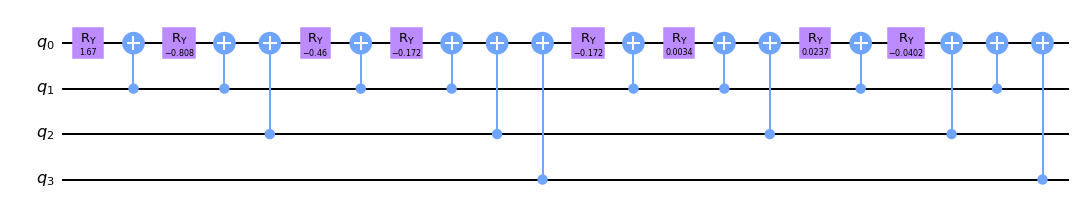

In [574]:
circ = Ry_4(CS, name = '')
circ.draw('mpl')

#### Multiplexed $R_z$ gate decomposition (4-qubits)

The matrices $D_B, D_A$ are diagonal matrices which has the form $\begin{pmatrix} D_n &  \\  & D_n^\dagger \end{pmatrix}$, where $D = \text{diag} \bigg{\{} e^{-\frac{i\phi_1}{2}}, e^{-\frac{i\phi_2}{2}}, ..., e^{-\frac{i\phi_{2^n}}{2}} \bigg{\}}$. We can extract the set of angles $\{\phi_i\}_{i = 1}^{2^{n-1}}$ with the ```np.angle``` method in numpy.

In [577]:
def Rz_4(D, name):
    
    '''Construct a 4-qubits Rz gate given a diagonal matrix'''

    p = np.angle(np.diag(D))*-2

    aae(np.diag(np.exp(-1j*p/2)), D) ### Check equality to D

    ### The parameters generation is identical to multiplexed Ry
    b0 = (p[0]+p[1]+p[2]+p[3]+p[4]+p[5]+p[6]+p[7])/8
    b1 = (p[0]+p[1]+p[2]+p[3]-p[4]-p[5]-p[6]-p[7])/8
    b2 = (p[0]+p[1]-p[2]-p[3]+p[4]+p[5]-p[6]-p[7])/8
    b3 = (p[0]+p[1]-p[2]-p[3]-p[4]-p[5]+p[6]+p[7])/8
    b4 = (p[0]-p[1]+p[2]-p[3]+p[4]-p[5]+p[6]-p[7])/8
    b5 = (p[0]-p[1]+p[2]-p[3]-p[4]+p[5]-p[6]+p[7])/8
    b6 = (p[0]-p[1]-p[2]+p[3]+p[4]-p[5]-p[6]+p[7])/8
    b7 = (p[0]-p[1]-p[2]+p[3]-p[4]+p[5]+p[6]-p[7])/8

    ### Constructing multiplexed Rz gate
    circ = QuantumCircuit(4)
    circ.rz(b0, 0)
    circ.cx(1, 0)
    circ.rz(b1, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.rz(b2, 0)
    circ.cx(1, 0)
    circ.rz(b3, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.cx(3, 0)
    circ.rz(b4, 0)
    circ.cx(1, 0)
    circ.rz(b5, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.rz(b6, 0)
    circ.cx(1, 0)
    circ.rz(b7, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.cx(3, 0)

    aae(Operator(circ.reverse_bits()).data, block_diag(D, dagger(D))) # Check equality with D
    
    circ.name = name

    return circ

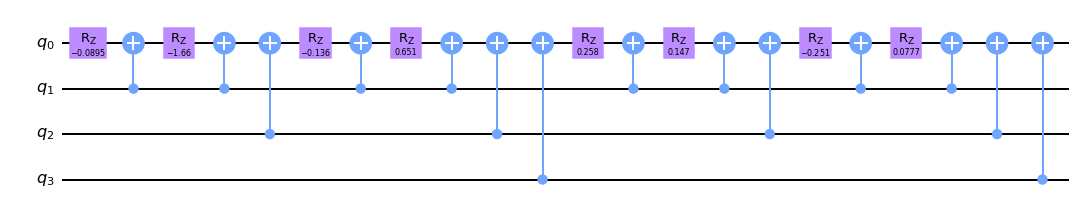

In [320]:
### Work example with matrix DA
circ = Rz_4(DA, name = '')
circ.draw('mpl')

#### 3-qubit decompositions

We now proceed with decomposing decomposing 3-qubits unitary. Again we will focus on the multiplexed $R^3_y$, and $R^3_z$ gates. This process is a simpler subset of the steps for $R^4_y$ and $R_z^4$ gates.

In [576]:
# Create a random 3-qubits unitary and decompose this into smaller blocks
U = random_unitary(dims = 8).data

U4, DB, U3, CS, U2, DA, U1 = one_level_decomp(U) 

#### Multiplexed $R_y$ gate decomposition (3-qubits)

In [578]:
def Ry_3(CS):
    
    '''Construct a 3-qubits Ry gate given a CS matrix'''
    
    n = int(np.log2(len(CS)))
    
    t = np.array([np.arctan2(CS[2**(n-1) + i, i], CS[i, i])*2 for i in range(2**(n-1))])

    aae(np.block([[np.diag(np.cos(t/2)), np.diag(-np.sin(t/2))], 
                  [np.diag(np.sin(t/2)), np.diag(np.cos(t/2))]]), CS) ### Check equality to CS

    a0 = (t[0]+t[1]+t[2]+t[3])/4
    a1 = (t[0]+t[1]-t[2]-t[3])/4
    a2 = (t[0]-t[1]+t[2]-t[3])/4
    a3 = (t[0]-t[1]-t[2]+t[3])/4

    ### Constructing multiplexed Ry gate
    circ = QuantumCircuit(3)
    circ.ry(a0, 0)
    circ.cx(1, 0)
    circ.ry(a1, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.ry(a2, 0)
    circ.cx(1, 0)
    circ.ry(a3, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)

    aae(Operator(circ.reverse_bits()).data, CS) # Check equality with CS
    
    return circ

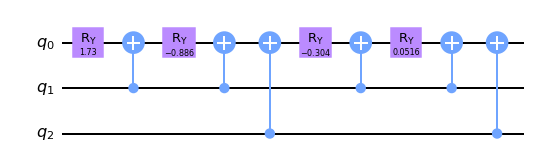

In [323]:
circ = Ry_3(CS)
circ.draw('mpl')

#### Multiplexed $R_z$ gate decomposition (4-qubits)

In [579]:
def Rz_3(D):
    
    '''Construct a 3-qubits Rz gate given a diagonal matrix'''

    p = np.angle(np.diag(D))*-2

    aae(np.diag(np.exp(-1j*p/2)), D) ### Check equality to D

    b0 = (p[0]+p[1]+p[2]+p[3])/4
    b1 = (p[0]+p[1]-p[2]-p[3])/4
    b2 = (p[0]-p[1]+p[2]-p[3])/4
    b3 = (p[0]-p[1]-p[2]+p[3])/4

    ### Constructing multiplexed Rz gate
    circ = QuantumCircuit(3)
    circ.rz(b0, 0)
    circ.cx(1, 0)
    circ.rz(b1, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)
    circ.rz(b2, 0)
    circ.cx(1, 0)
    circ.rz(b3, 0)
    circ.cx(1, 0)
    circ.cx(2, 0)

    aae(Operator(circ.reverse_bits()).data, block_diag(D, dagger(D))) # Check equality with D
    
    return circ

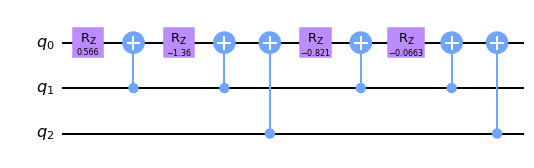

In [325]:
circ = Rz_3(DA)
circ.draw('mpl')

#### Full Decomposition

We will now aggregate everything shown above to form a general decomposition for $4$-qubit unitary gate. We start building from the base up, first constructing the general $3$-qubits gate, four of which are used in constructing the general $4$-qubits gate.

In [581]:
def construct_3_qubits(U, name = None):
    
    '''Decompose an arbitrary 3-qubits matrix into circuit with 2-qubits gates'''
    
    U4, DB, U3, CS, U2, DA, U1 = one_level_decomp(U)

    circ = QuantumCircuit(3)
    circ.unitary(U1, [2, 1])
    circ.append(Rz_3(DA), [0, 1, 2])
    circ.unitary(U2, [2, 1])
    circ.append(Ry_3(CS), [0, 1, 2])
    circ.unitary(U3, [2, 1])
    circ.append(Rz_3(DB), [0, 1, 2])
    circ.unitary(U4, [2, 1])

    aae(Operator(circ.reverse_bits()).data, U) # Check Equality to Input Matrix
    
    circ.name = name
    
    return circ

In [582]:
def construct_4_qubits(U):
    
    '''Decompose an arbitrary 4-qubits matrix into circuit with 3-qubits gates'''

    U4, DB, U3, CS, U2, DA, U1 = one_level_decomp(U)

    circ = QuantumCircuit(4)

    circ.append(construct_3_qubits(U1, ' U1 '), range(1, 4))
    circ.append(Rz_4(DA, ' DA '), range(4))
    circ.append(construct_3_qubits(U2, 'U2'), range(1, 4))

    circ.append(Ry_4(CS, ' CS '), range(4))

    circ.append(construct_3_qubits(U3, ' U3 '), range(1, 4))
    circ.append(Rz_4(DB, ' DB '), range(4))
    circ.append(construct_3_qubits(U4, ' U4 '), range(1, 4))
    
    aae(Operator(circ.reverse_bits()).data, U) # Check Equality to Input Matrix

    return circ

We will construct the exact unitary that contains our random vectors. We will calculate that cost of the resulting circuit to show that the similarity to our initial matrix is absolute.

loss: -3.552713678800501e-15


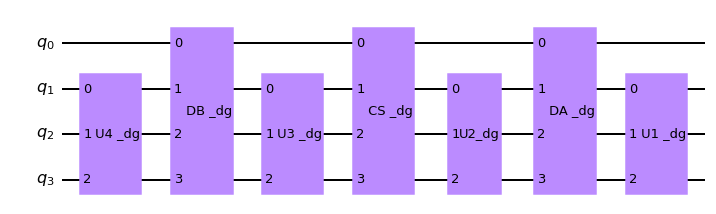

In [640]:
circ = construct_4_qubits(random_matrix)
unitary = Operator(circ.reverse_bits()).data
yhat = unitary@X

print(f'loss: {loss(y, yhat)}') # Calculate cost

circ = circ.inverse() # Invert circuit to get our desired matrix

circ.draw('mpl')

#### Benchmark With Qiskit's Construction

We see that our decompose is superior to that of Qiskit in both single qubit $U$ gate and double qubits $CX$ gate. Across both examples of $3$ and $4$ qubits gates, our technique uses 25% less gates that of Qiskit's. In fact, there exists further optimizations outlined in the original paper by author that can get the $3$-qubit cost to $20$ $CX$, and the $4$-qubit cost to $100$. However, these optimizations are outside the scope of this notebook as the above construction suffices as proof of concept.

In [584]:
### Three Qubit Decomposition

U = random_unitary(8).data

circ = construct_3_qubits(U)
aae(Operator(circ.reverse_bits()).data, U)
print('Our: ', transpile(circ, basis_gates = ['cx', 'u']).count_ops())

qc = QuantumCircuit(3)
qc.unitary(U, range(3))
print('Qiskit: ',  transpile(qc, basis_gates = ['cx', 'u']).count_ops())

Our:  OrderedDict([('u', 44), ('cx', 30)])
Qiskit:  OrderedDict([('u', 56), ('cx', 41)])


In [585]:
### Four Qubit Decomposition

U = random_unitary(16).data

circ = construct_4_qubits(U)
aae(Operator(circ.reverse_bits()).data, U)
print('Our: ', transpile(circ, basis_gates = ['cx', 'u']).count_ops())

qc = QuantumCircuit(4)
qc.unitary(U, range(4))
print('Qiskit: ',  transpile(qc, basis_gates = ['cx', 'u']).count_ops())

Our:  OrderedDict([('u', 200), ('cx', 162)])
Qiskit:  OrderedDict([('u', 261), ('cx', 218)])


### 4. Hybrid SWAP Test Algorithm

When working with higher and higher number of qubits, the number of entries in our unitary matrices scales $4^{n}$. This makes it prohibitively expensive to simulate a large quantum circuit classically. Quantum computers offers a native solutions to our problem at hand. In a way, we use it to optimize itself. In this section, we describe a hybrid approach for cost calculation when training variational circuits. The main idea of this approach comes from the [SWAP test](https://en.wikipedia.org/wiki/Swap_test) (outlined in the previous QOSF cohort task). Here, we will not discuss all the details of the procedure but simply provide an example, which is indicative of the general circuit. Simply put, the SWAP test compares two states of the quantum states and returns their similarity in the probability of measuring the state $|0\rangle$. More specifically, for a given states $|\psi\rangle$ and $|\phi\rangle$, the complex dot product of the two states is given by

$$|\langle\psi|\phi\rangle|^2 = 2P_{\searrow|0\rangle} - 1$$

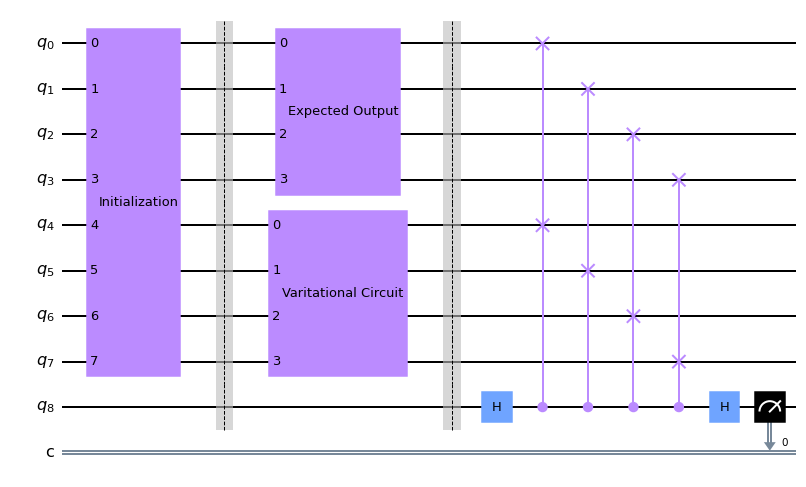

In [408]:
circ = QuantumCircuit(9, 1)

circ.unitary(np.identity(256), qubits = range(8), label = 'Initialization')

circ.barrier()

### Stand-in gate
circ.unitary(np.identity(16), qubits = range(4), label = 'Expected Output')
circ.unitary(np.identity(16), qubits = range(4, 8), label = 'Varitational Circuit')

circ.barrier()
circ.h(8)
for i in range(4):
    circ.cswap(8, i, i+4)
circ.h(8)

circ.measure(8, 0)

circ.draw("mpl")

$$\text{Example of the SWAP Test Circuit for $4$-qubits Unitary}$$

To train an $n$-qubit cirucit, we use a SWAP test circuit of size $2n+1$. The first $n$ qubits will implement the exact expected output by procedure outlined in Section 3. The next $n$ qubits will implement the variational circuit with tunable single qubit parameteric gates. Finally, we will implement the SWAP test and read out the measurement on the bottom last qubits.

##### Initialization

Before training our circuit, it is important to initialized our qubits to the appropriate states. Since we are putting our states through two separate subcircuits, we need to initialized two copies of the input states. For our task, we need to initialize the state $|0101 \ 0101\rangle$, $|0011 \ 0011\rangle$, $|1010 \ 1010\rangle$, $|1100 \ 1100\rangle$. Here we are ignoring the last qubits, which will always be initialized to $|0\rangle$. In some special cases, we can pass in the inputs as superpositions of the individual states. When the number of inputs is large, this is an important optimization in terms of passes to the circuit.

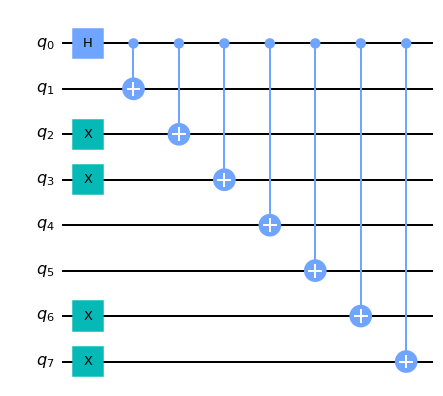

In [416]:
circ = QuantumCircuit(8)
circ.h(0)

circ.x([2, 3, 6, 7])
circ.cx([0], range(1, 8))

circ.draw('mpl')

$$\text{The above circuit initialized the state } \frac{1}{\sqrt{2}}|0011 \ 0011\rangle + \frac{1}{\sqrt{2}}|1100 \ 1100\rangle$$

#### Defining the Cost Function

We keep the same convention of our loss function in section 2. For our task with four random states, the loss function is given by

$$\begin{align*}\text{loss} &= 1 - \frac{  |\langle y_1 | \hat{y}_1  \rangle|^2 + |\langle y_2 | \hat{y}_2  \rangle|^2 + |\langle y_3 | \hat{y}_3  \rangle|^2 + |\langle y_4 | \hat{y}_4  \rangle|^2 }{4} \\ &= 2 - \frac{P_3 + P_5 + P_{10} + P_{12}}{2}\end{align*}$$

where $P_i$ is the probability of measuring $|0\rangle$ in the bottom qubit given the input $|i, i\rangle$. In general,

$$\text{loss} = 2 - \frac{2}{m} \sum_j^m P_j$$

where $m$ is the number of inputs, and $P_j$ is the measurement probability of the $j$th input

#### Training the Variational Circuit

We after we pass in all our inputs, we aggregate the measurement probabilities to calculate the cost function. We pass this to a classical optimizer to optimize the parameters in our variational circuit. For our example, we choose a relatively easy circuit run. The reason for this is that an $8$ qubit circuit is very expensive to simulate classically with ```qasm_simulator```. However, this works as proof of concept and allows us to demonstrate the use of superposition inputs. 

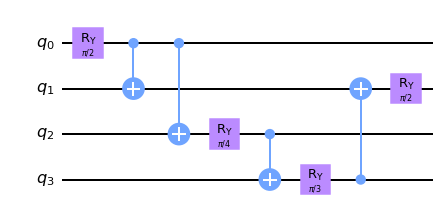

In [642]:
### Expected Circuit
yhat_circ = QuantumCircuit(4)
yhat_circ.ry(np.pi/2, 0)
yhat_circ.cx(0, 1)
yhat_circ.cx(0, 2)
yhat_circ.ry(np.pi/4, 2)
yhat_circ.cx(2, 3)
yhat_circ.ry(np.pi/3, 3)
yhat_circ.cx(3, 1)
yhat_circ.ry(np.pi/2, 1)
yhat_circ.name = 'Expected Output'

yhat_circ.draw('mpl')

In [655]:
### Matrix of the circuit
y_mat = Operator(yhat_circ).data

Matrix(y_mat)

Matrix([
[  0.400051572595633,  -0.400051572595633,  -0.400051572595633,   0.400051572595633,  -0.165706787017796,   0.165706787017796,   0.165706787017796,  -0.165706787017796,  -0.230969883127822,   0.230969883127822,  0.230969883127822,  -0.230969883127822, 0.0956708580912724, -0.0956708580912724, -0.0956708580912724,  0.0956708580912724],
[  0.165706787017796,   0.165706787017796,  -0.165706787017796,  -0.165706787017796,  -0.400051572595633,  -0.400051572595633,   0.400051572595633,   0.400051572595633, -0.0956708580912724, -0.0956708580912724, 0.0956708580912724,  0.0956708580912724,  0.230969883127822,   0.230969883127822,  -0.230969883127822,  -0.230969883127822],
[  0.400051572595633,  -0.400051572595633,   0.400051572595633,  -0.400051572595633,  -0.165706787017796,   0.165706787017796,  -0.165706787017796,   0.165706787017796,  -0.230969883127822,   0.230969883127822, -0.230969883127822,   0.230969883127822, 0.0956708580912724, -0.0956708580912724,  0.0956708580912724, -0.09

For our variational circuit, we also try to limit the number of tunable paramters. However, we make sure to add some redundant parameters to make sure the training really works.

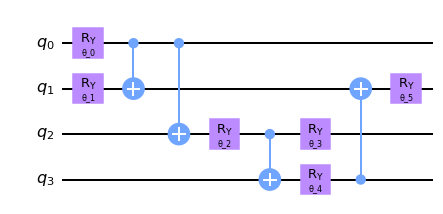

In [673]:
#### Variational Circuit

param = [Parameter(f'θ_{i}') for i in range(6)]
var_circ = QuantumCircuit(4)
var_circ.ry(param[0], 0)

### Redundant Parameter
var_circ.ry(param[1], 1)
var_circ.cx(0, 1)
var_circ.cx(0, 2)
var_circ.ry(param[2], 2)
var_circ.cx(2, 3)

### Redundant Parameter
var_circ.ry(param[3], 2)
var_circ.ry(param[4], 3)
var_circ.cx(3, 1)
var_circ.ry(param[5], 1)

var_circ.name = 'Variational Circuit'

var_circ.draw('mpl')

In [645]:
simulator = BasicAer.get_backend('qasm_simulator')

def cost(param):
    inp_list = ['0011', '1100']

    prob_sum = 0

    for inp in inp_list:

        circ = QuantumCircuit(9, 1)

        if inp == '0011':
            ## 0011 and 1100 input
            circ.h(0)

            circ.x([2, 3, 6, 7])
            circ.cx([0], range(1, 8))

        else:
            ## 0101 and 1010 input
            circ.h(0)
            circ.x([1, 3, 5, 7])
            circ.cx([0], range(1, 8))

        circ.barrier()
        
        ### Expected Value
        circ.append(yhat_circ, range(4))
        
        ### Variational Circuit
        circ.append(var_circ, range(4, 8))
        circ = circ.bind_parameters(param)

        circ.barrier()

        circ.h(8)
        for i in range(4):
            circ.cswap(8, i, i+4)
        circ.h(8)

        circ.measure(8, 0)

        ### Run circuit on 1000 iterations
        prob_sum += execute(circ, simulator, shots = 5000).result().get_counts()['0'] / 5000
    
    ### Since we are running on 2 examples, the cost function changes by a little bit
    return 2 - prob_sum

We initialized our parameters to $0$ and train using the method ```COBYLA```.

In [650]:
x0 = np.zeros(6)

res = minimize(cost, x0, method = 'COBYLA')

res

     fun: 0.0028000000000001357
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 78
  status: 1
 success: True
       x: array([ 1.53251151, -0.03217651,  0.74091228, -0.01003188,  1.132503  ,
        1.56940811])

loss: 1.7759498727176748e-07


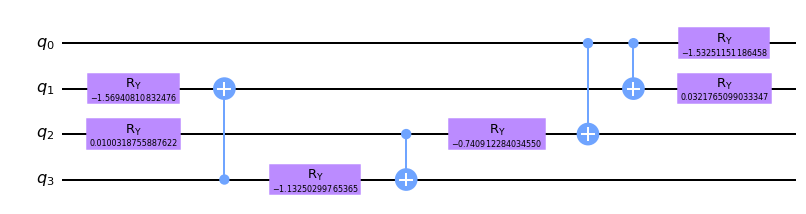

In [674]:
var_circ = var_circ.bind_parameters(res.x)

unitary = Operator(var_circ).data
yhat_mat = unitary@X

print(f'loss: {1 - loss(y_mat, yhat_mat)}') # Calculate cost

var_circ = var_circ.inverse() # Invert circuit to get our desired matrix

var_circ.draw('mpl')

If we look at our training parameters, we can quickly see that our circuit has pick our the correct values. In fact, it has reduce to almost zero the redundant parameters. This shows that the SWAP test circuit is viable on a quantum computer. For our circuit, the number of auxillary $CX$ gate scales linearly with the number of qubits. The applications of this method is to optimize an $n$-qubits unitary decomposition from the $O(4^n)$ number of $CX$ used.